# Present Wrapping Problem

The PWP can be seen as a specialization of the more general rectangle packing problem, in which we have a set of rectangles (our presents) of given dimensions that have to fit into a pre-determined square (the wrapping paper) of a given size. The great thing about PWP is that we kwow the items will perfectly fit into the given container, without any kind of wasted space.

We decided to use a list of bottom left corners (with the same index set as the list of presents shapes) as the solution representation. So, the main constraint we have dealt with are the following ones:
* Rectangles cannot overlap
* Rectangles should be completely contained inside the wrapping paper
* No wasted paper
* Rectangles cannot be rotated (unless specified)

In [2]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import string
import random
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

This section contains different utility functions, needed to deal with instances input/output, results handling (solutions graphical representation and running time plots), ...

In [3]:
def rand_str(size=10, chars=string.ascii_uppercase + string.digits):
    '''
    Returns a string of the given length with randomly chosen characters
    '''
    return ''.join(random.choice(chars) for _ in range(size))

In [4]:
def read_input(path):
    '''
    Read the given input instance, which should have the following format:

    W H
    N
    P1X P1Y
    ...
    PNX PNY

    Here, PIJ means present I, coordinate J, while W and H are the paper's dimensions
    '''
    file = open(path, "r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [203]:
def show_solutions(w_paper, h_paper, n, presents, solutions, model):
    '''
    Show each and every solution as 2D plots
    '''
    if not isinstance(solutions,list):
        solutions = [solutions]

    colors = np.random.rand(n, 3)
    for solution in solutions:
        show_solution(w_paper, h_paper, n, presents, solution, model, colors)

def show_solution(w_paper, h_paper, n, presents, solution, model, colors=None):
    '''
    Show the given solution as a 2D plot. 
    The solution should be a list of bottom left corners, 
    contained in the given w_paper and h_paper margins
    '''
    assert(isinstance(w_paper, int))
    assert(isinstance(h_paper, int))
    assert(isinstance(presents, list))
    assert(isinstance(n, int) and n == len(presents))
    assert(isinstance(solution, dict))
    assert('bl_corners' in solution)
    assert(len(presents) == len(solution['bl_corners']))

    bl_corners = solution['bl_corners']
    if 'kind' in solution:
        for i in range(n):
            if solution['kind'][i] % 2 == 0:
                presents[i][1], presents[i][0] = presents[i][0], presents[i][1]

    if colors is None:
        colors = np.random.rand(n, 3)
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            bl_corners[i],
            presents[i][0],
            presents[i][1],
            facecolor=colors[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    plt.xlabel("Width")
    plt.ylabel("Height")
    print(f"Solution: {bl_corners}")
    plt.savefig(f"plots/{model}/{w_paper}x{h_paper}-sol.png", dpi=300, bbox_inches='tight')
    output(w_paper, h_paper, n, presents, bl_corners, model)
    plt.show()

In [205]:
def show_running_times(instances, times, max_time, model):
    '''
    Show instance size versus running time plot, where instances
    taking more than `max_time` milliseconds will be marked with an X
    '''
    no_goods = [i for i in range(len(instances)) if times[i] > (max_time / 1000)]
    goods = [i for i in range(len(instances)) if i not in no_goods]
    fig = plt.figure(figsize=(12, 8), dpi= 100, facecolor='w', edgecolor='k')
    plt.xlabel("Instance size")
    plt.ylabel("Total running time (seconds)")
    plt.plot(
        [x for i, x in enumerate(instances) if i in goods], 
        [t for i, t in enumerate(times) if i in goods], 
        marker='o', linestyle='dashed', linewidth=2, markersize=12
    )
    plt.plot(
        [x for i, x in enumerate(instances) if i in no_goods], 
        [t for i, t in enumerate(times) if i in no_goods], 
        marker='x', markersize=12
    )
    plt.xticks(instances)
    plt.grid()
    plt.savefig(f"plots/{model}/times.png", dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
def order_presents(presents, method='height', reverse=False):
    '''
    Order presents, increasing or decreasing, 
    by the given method (area, height, width)
    '''
    to_sort = (
        [e[0] * e[1] for e in presents] if method == 'area'
        else [e[1] for e in presents] if method == 'height'
        else [e[0] for e in presents] if method == 'width'
        else None
    )
    sorted_indices = sorted(range(len(to_sort)), key=lambda k: to_sort[k], reverse=reverse)
    presents = [presents[i] for i in sorted_indices]
    return presents, sorted_indices

In [8]:
def output(w_paper, h_paper, n, presents, bl_corners, model):
    '''
    Write the given solution to an output file, in a specific output folder,
    with the following format:
    
    W H
    N
    P1X P1Y  C1X C1Y
    ...
    PNX PNY  CNX CNY

    Here, PIJ means present I, coordinate J; 
    CIJ means coordinate J of the bottom left corner of present I; 
    while W and H are the paper's dimensions
    '''
    out_file = open(f"out/{model}/{w_paper}x{h_paper}-out.txt", "w+")
    print(f"{w_paper} {h_paper}", file=out_file)
    print(f"{n}", file=out_file)
    for present, position in zip(presents, bl_corners):
        present_x, present_y = present
        position_x, position_y = position
        print(f"{present_x} {present_y}{2 * ' '}{position_x} {position_y}", file=out_file)
    out_file.close()

## CP

In this section, we reported various CP models, in which we tried different approaches, evolving from one another on the basis of references and own ideas. Some of them tend to be faster in a specific subset of instances, w.r.t. the others. In the final model, we tried to put together the different key-points of each model.

CP models are implemented with the MiniZinc language and models execution is managed by the official MiniZinc Jupyter extension, called iMiniZinc.

### Input

The following subsection is dedicated to input handling. In particular, if we want to test a single instance, we can set the `instance` variable and execute the code below to visualize one associated solution. If instead we want to test every single instance, we can just set the `instance` variable to the special value `None` and still execute the code below to both visualize every computed solution and analyze running times for every instance.

In [206]:
instance = None
min_instance, max_instance = 8, 40
max_time = 2 * 1000 # milliseconds

Paper dimensions: 8x8
Presents dimensions: [[3, 3], [3, 5], [5, 3], [5, 5]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatIntVars=21
mzn-stat: flatIntConstraints=8
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.0973449
mzn-stat-end
mzn-stat: initTime=0.000613
mzn-stat: solveTime=0.000585
mzn-stat: solutions=1
mzn-stat: variables=53
mzn-stat: propagators=0
mzn-stat: propagations=8
mzn-stat: nodes=1
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=0
mzn-stat-end
Solution: [[5, 5], [5, 0], [0, 5], [0, 0]]


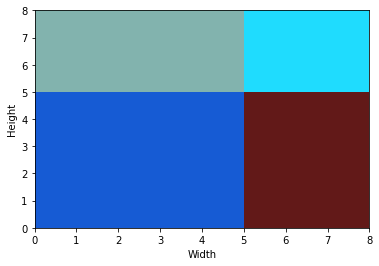


Paper dimensions: 9x9
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=80
mzn-stat: flatBoolConstraints=67
mzn-stat: flatIntConstraints=197
mzn-stat: evaluatedReifiedConstraints=17
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: eliminatedImplications=30
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.111951
mzn-stat-end
mzn-stat: initTime=0.002309
mzn-stat: solveTime=0.000243
mzn-stat: solutions=1
mzn-stat: variables=225
mzn-stat: propagators=252
mzn-stat: propagations=545
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[3, 6], [6, 5], [6, 0], [3, 0], [0, 0]]


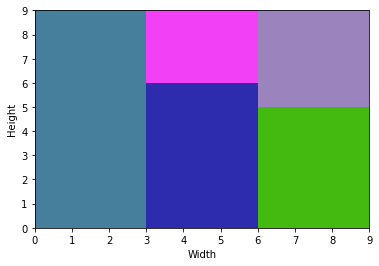


Paper dimensions: 10x10
Presents dimensions: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=109
mzn-stat: flatIntVars=65
mzn-stat: flatBoolConstraints=42
mzn-stat: flatIntConstraints=149
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=103
mzn-stat: eliminatedImplications=12
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.112081
mzn-stat-end
mzn-stat: initTime=0.001994
mzn-stat: solveTime=0.000217
mzn-stat: solutions=1
mzn-stat: variables=190
mzn-stat: propagators=146
mzn-stat: propagations=360
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
Solution: [[4, 7], [7, 6], [7, 0], [4, 0], [0, 6], [0, 0]]


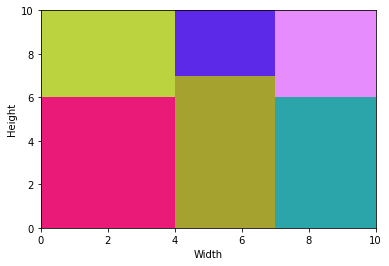


Paper dimensions: 11x11
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=91
mzn-stat: flatIntVars=63
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=147
mzn-stat: evaluatedReifiedConstraints=7
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.101195
mzn-stat-end
mzn-stat: initTime=0.002
mzn-stat: solveTime=0.000348
mzn-stat: solutions=1
mzn-stat: variables=154
mzn-stat: propagators=164
mzn-stat: propagations=1068
mzn-stat: nodes=26
mzn-stat: failures=9
mzn-stat: restarts=0
mzn-stat: peakDepth=10
mzn-stat-end
Solution: [[5, 8], [5, 4], [8, 6], [8, 0], [0, 8], [0, 4], [0, 0]]


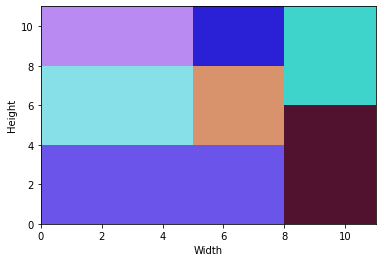


Paper dimensions: 12x12
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=120
mzn-stat: flatIntVars=72
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=183
mzn-stat: evaluatedReifiedConstraints=8
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.092406
mzn-stat-end
mzn-stat: initTime=0.00218
mzn-stat: solveTime=0.000437
mzn-stat: solutions=1
mzn-stat: variables=192
mzn-stat: propagators=193
mzn-stat: propagations=2120
mzn-stat: nodes=34
mzn-stat: failures=13
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[3, 6], [6, 8], [9, 7], [3, 0], [9, 0], [6, 0], [0, 0], [0, 9]]


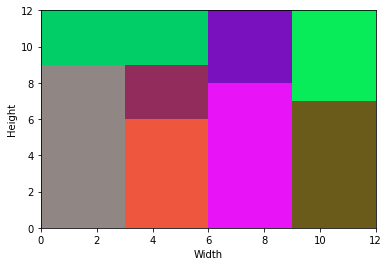


Paper dimensions: 13x13
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=153
mzn-stat: flatIntVars=81
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=223
mzn-stat: evaluatedReifiedConstraints=9
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.0978095
mzn-stat-end
mzn-stat: initTime=0.002342
mzn-stat: solveTime=0.000815
mzn-stat: solutions=1
mzn-stat: variables=234
mzn-stat: propagators=251
mzn-stat: propagations=3450
mzn-stat: nodes=102
mzn-stat: failures=46
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[4, 10], [4, 6], [7, 8], [10, 7], [10, 0], [7, 0], [0, 10], [0, 6], [0, 0]]


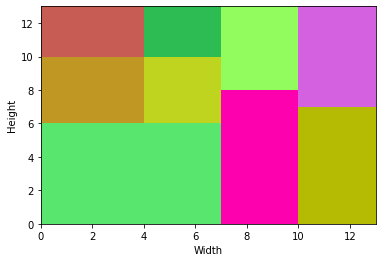


Paper dimensions: 14x14
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=310
mzn-stat: flatIntVars=147
mzn-stat: flatBoolConstraints=140
mzn-stat: flatIntConstraints=409
mzn-stat: evaluatedReifiedConstraints=25
mzn-stat: evaluatedHalfReifiedConstraints=327
mzn-stat: eliminatedImplications=63
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.137185
mzn-stat-end
mzn-stat: initTime=0.00425
mzn-stat: solveTime=0.000308
mzn-stat: solutions=1
mzn-stat: variables=473
mzn-stat: propagators=472
mzn-stat: propagations=1206
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[11, 11], [11, 7], [5, 9], [8, 8], [11, 0], [8, 0], [5, 0], [0, 10], [0, 0]]


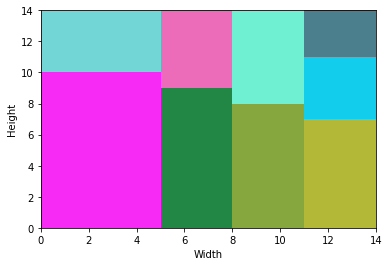


Paper dimensions: 15x15
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=87
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=264
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.110486
mzn-stat-end
mzn-stat: initTime=0.003462
mzn-stat: solveTime=0.000802
mzn-stat: solutions=1
mzn-stat: variables=281
mzn-stat: propagators=275
mzn-stat: propagations=2681
mzn-stat: nodes=77
mzn-stat: failures=33
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[3, 12], [9, 8], [12, 7], [6, 9], [12, 0], [9, 0], [6, 0], [3, 0], [0, 0], [9, 12]]


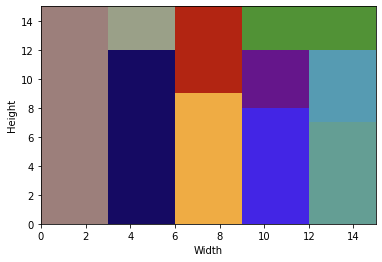


Paper dimensions: 16x16
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=90
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=267
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.100336
mzn-stat-end
mzn-stat: initTime=0.008773
mzn-stat: solveTime=0.002122
mzn-stat: solutions=1
mzn-stat: variables=280
mzn-stat: propagators=284
mzn-stat: propagations=3004
mzn-stat: nodes=88
mzn-stat: failures=39
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end
Solution: [[13, 13], [7, 12], [13, 8], [10, 10], [4, 9], [13, 0], [10, 0], [7, 0], [0, 9], [0, 0]]


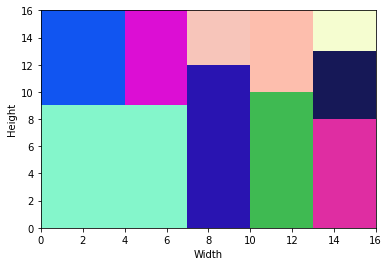


Paper dimensions: 17x17
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=276
mzn-stat: flatIntVars=108
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=367
mzn-stat: evaluatedReifiedConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.100571
mzn-stat-end
mzn-stat: initTime=0.003303
mzn-stat: solveTime=0.011695
mzn-stat: solutions=1
mzn-stat: variables=384
mzn-stat: propagators=417
mzn-stat: propagations=61168
mzn-stat: nodes=1370
mzn-stat: failures=678
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[14, 14], [4, 13], [11, 9], [14, 8], [4, 6], [14, 0], [11, 0], [0, 14], [7, 6], [0, 0], [7, 14], [4, 0]]


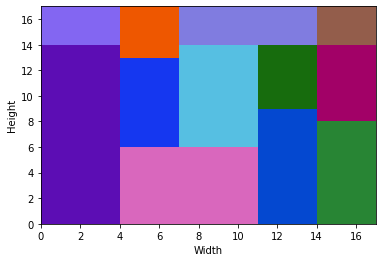


Paper dimensions: 18x18
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=575
mzn-stat: flatIntVars=209
mzn-stat: flatBoolConstraints=224
mzn-stat: flatIntConstraints=706
mzn-stat: evaluatedReifiedConstraints=29
mzn-stat: evaluatedHalfReifiedConstraints=606
mzn-stat: eliminatedImplications=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.131663
mzn-stat-end
mzn-stat: initTime=0.0061
mzn-stat: solveTime=0.00047
mzn-stat: solutions=1
mzn-stat: variables=848
mzn-stat: propagators=706
mzn-stat: propagations=2684
mzn-stat: nodes=8
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end
Solution: [[12, 15], [15, 14], [12, 10], [15, 8], [9, 11], [15, 0], [12, 0], [9, 0], [5, 15], [5, 11], [5, 6], [5, 0], [0, 15], [0, 11], [0, 6], [0, 0]

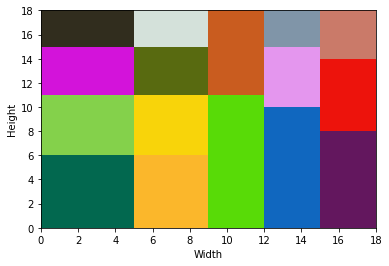


Paper dimensions: 19x19
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=893
mzn-stat: flatIntVars=402
mzn-stat: flatBoolConstraints=468
mzn-stat: flatIntConstraints=1199
mzn-stat: evaluatedReifiedConstraints=61
mzn-stat: evaluatedHalfReifiedConstraints=1056
mzn-stat: eliminatedImplications=275
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.191482
mzn-stat-end
mzn-stat: initTime=0.010364
mzn-stat: solveTime=0.000832
mzn-stat: solutions=1
mzn-stat: variables=1322
mzn-stat: propagators=1502
mzn-stat: propagations=6243
mzn-stat: nodes=10
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=7
mzn-stat-end
Solution: [[16, 16], [13, 15], [13, 10], [7, 13], [16, 9], [10, 11], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 14], [0, 8], [0, 0]]


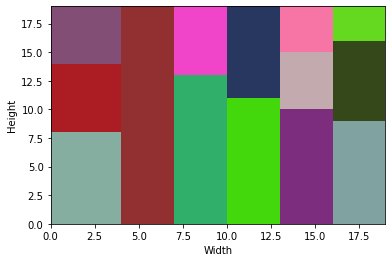


Paper dimensions: 20x20
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=800
mzn-stat: flatIntVars=338
mzn-stat: flatBoolConstraints=379
mzn-stat: flatIntConstraints=1049
mzn-stat: evaluatedReifiedConstraints=56
mzn-stat: evaluatedHalfReifiedConstraints=888
mzn-stat: eliminatedImplications=192
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.148056
mzn-stat-end
mzn-stat: initTime=0.009471
mzn-stat: solveTime=0.000542
mzn-stat: solutions=1
mzn-stat: variables=1138
mzn-stat: propagators=1380
mzn-stat: propagations=3564
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end
Solution: [[8, 17], [14, 16], [17, 15], [14, 10], [17, 8], [17, 0], [11, 11], [14, 0], [11, 0], [8, 0], [0, 17], [4, 11], [4, 0], [0, 0]]


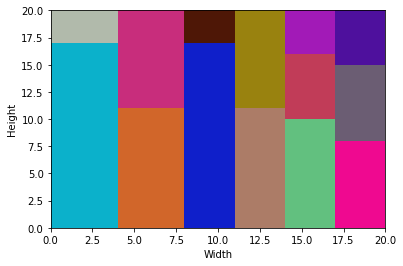


Paper dimensions: 21x21
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=763
mzn-stat: flatIntVars=311
mzn-stat: flatBoolConstraints=355
mzn-stat: flatIntConstraints=985
mzn-stat: evaluatedReifiedConstraints=46
mzn-stat: evaluatedHalfReifiedConstraints=857
mzn-stat: eliminatedImplications=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.14872
mzn-stat-end
mzn-stat: initTime=0.008652
mzn-stat: solveTime=0.000489
mzn-stat: solutions=1
mzn-stat: variables=1114
mzn-stat: propagators=1119
mzn-stat: propagations=3080
mzn-stat: nodes=4
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=3
mzn-stat-end
Solution: [[9, 18], [18, 17], [15, 16], [15, 10], [12, 14], [18, 9], [18, 0], [15, 0], [12, 0], [9, 0], [5, 17], [5, 11], [5, 0], [0, 15], [0, 0]]


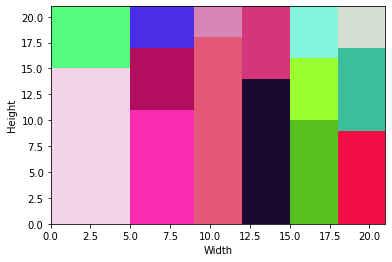


Paper dimensions: 22x22
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=496
mzn-stat: flatIntVars=141
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=612
mzn-stat: evaluatedReifiedConstraints=16
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.118972
mzn-stat-end
mzn-stat: initTime=0.006109
mzn-stat: solveTime=0.009625
mzn-stat: solutions=1
mzn-stat: variables=642
mzn-stat: propagators=654
mzn-stat: propagations=29314
mzn-stat: nodes=833
mzn-stat: failures=408
mzn-stat: restarts=0
mzn-stat: peakDepth=29
mzn-stat-end
Solution: [[19, 19], [16, 18], [10, 13], [13, 12], [16, 11], [7, 14], [19, 10], [19, 0], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 19], [0, 0], [10, 18]]


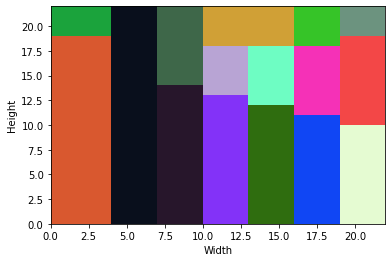


Paper dimensions: 23x23
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=0
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=703
mzn-stat: flatIntVars=171
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=843
mzn-stat: evaluatedReifiedConstraints=19
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.122046
mzn-stat-end
No solution has been found
mzn-stat: initTime=0.00765
mzn-stat: solveTime=1.87816
mzn-stat: solutions=0
mzn-stat: variables=874
mzn-stat: propagators=970
mzn-stat: propagations=6406939
mzn-stat: nodes=137469
mzn-stat: failures=68730
mzn-stat: restarts=0
mzn-stat: peakDepth=28
mzn-stat-end

Paper dimensions: 24x24
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3,

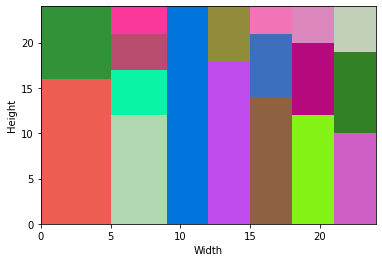


Paper dimensions: 25x25
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=703
mzn-stat: flatIntVars=168
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=840
mzn-stat: evaluatedReifiedConstraints=19
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.119527
mzn-stat-end
mzn-stat: initTime=0.009555
mzn-stat: solveTime=0.002711
mzn-stat: solutions=1
mzn-stat: variables=876
mzn-stat: propagators=919
mzn-stat: propagations=8888
mzn-stat: nodes=185
mzn-stat: failures=82
mzn-stat: restarts=0
mzn-stat: peakDepth=31
mzn-stat-end
Solution: [[19, 22], [22, 21], [13, 17], [3, 19], [6, 18], [16, 14], [19, 13], [22, 11], [22, 0], [19, 0], [16, 0], [13, 0], [6, 0], [3, 0], [0, 0],

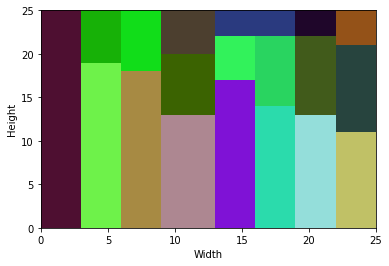


Paper dimensions: 26x26
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2124
mzn-stat: flatIntVars=900
mzn-stat: flatBoolConstraints=1111
mzn-stat: flatIntConstraints=2853
mzn-stat: evaluatedReifiedConstraints=118
mzn-stat: evaluatedHalfReifiedConstraints=2574
mzn-stat: eliminatedImplications=672
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.278666
mzn-stat-end
mzn-stat: initTime=0.049245
mzn-stat: solveTime=0.022223
mzn-stat: solutions=1
mzn-stat: variables=3024
mzn-stat: propagators=3904
mzn-stat: propagations=64913
mzn-stat: nodes=825
mzn-stat: failures=407
mzn-stat: restarts=0
mzn-stat: peakDepth=45
mzn-stat-end
Solution: [[23, 23], [20, 22], [17, 21], [17, 15], [8, 19], [20, 14], [11, 17]

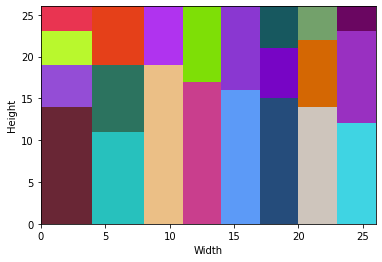


Paper dimensions: 27x27
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1766
mzn-stat: flatIntVars=692
mzn-stat: flatBoolConstraints=862
mzn-stat: flatIntConstraints=2305
mzn-stat: evaluatedReifiedConstraints=102
mzn-stat: evaluatedHalfReifiedConstraints=2049
mzn-stat: eliminatedImplications=474
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.258416
mzn-stat-end
mzn-stat: initTime=0.017698
mzn-stat: solveTime=0.007497
mzn-stat: solutions=1
mzn-stat: variables=2458
mzn-stat: propagators=3081
mzn-stat: propagations=36125
mzn-stat: nodes=530
mzn-stat: failures=260
mzn-stat: restarts=0
mzn-stat: peakDepth=32
mzn-stat-end
Solution: [[24, 24], [24, 20], [21, 22], [12, 21], [15, 20], [18, 19], [24, 11], [21, 12

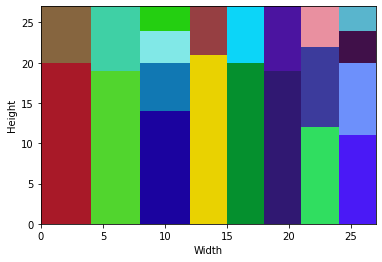


Paper dimensions: 28x28
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1724
mzn-stat: flatIntVars=632
mzn-stat: flatBoolConstraints=802
mzn-stat: flatIntConstraints=2209
mzn-stat: evaluatedReifiedConstraints=89
mzn-stat: evaluatedHalfReifiedConstraints=1978
mzn-stat: eliminatedImplications=420
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.251356
mzn-stat-end
mzn-stat: initTime=0.028733
mzn-stat: solveTime=0.002552
mzn-stat: solutions=1
mzn-stat: variables=2380
mzn-stat: propagators=2714
mzn-stat: propagations=16910
mzn-stat: nodes=90
mzn-stat: failures=41
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end
Solution: [[25, 25], [22, 24], [13, 23], [25, 19], [16, 21], [22, 16], [25, 10], [2

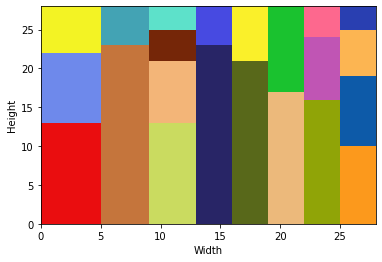


Paper dimensions: 29x29
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1848
mzn-stat: flatIntVars=605
mzn-stat: flatBoolConstraints=795
mzn-stat: flatIntConstraints=2302
mzn-stat: evaluatedReifiedConstraints=89
mzn-stat: evaluatedHalfReifiedConstraints=2056
mzn-stat: eliminatedImplications=372
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.245382
mzn-stat-end
mzn-stat: initTime=0.020619
mzn-stat: solveTime=0.031357
mzn-stat: solutions=1
mzn-stat: variables=2477
mzn-stat: propagators=2808
mzn-stat: propagations=76350
mzn-stat: nodes=1240
mzn-stat: failures=615
mzn-stat: restarts=0
mzn-stat: peakDepth=43
mzn-stat-end
Solution: [[17, 26], [20, 25], [23, 24], [17, 20], [20, 18], [26

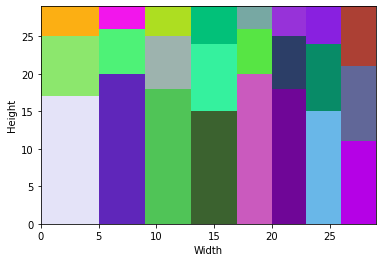


Paper dimensions: 30x30
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1510
mzn-stat: flatIntVars=631
mzn-stat: flatBoolConstraints=770
mzn-stat: flatIntConstraints=2006
mzn-stat: evaluatedReifiedConstraints=79
mzn-stat: evaluatedHalfReifiedConstraints=1816
mzn-stat: eliminatedImplications=455
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.238275
mzn-stat-end
mzn-stat: initTime=0.017877
mzn-stat: solveTime=0.006258
mzn-stat: solutions=1
mzn-stat: variables=2189
mzn-stat: propagators=2431
mzn-stat: propagations=20402
mzn-stat: nodes=289
mzn-stat: failures=141
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end
Solution: [[18, 27], [21, 26], [15, 25], [27, 24], [24, 23], [18, 19], [24, 14], [21, 16], [27, 1

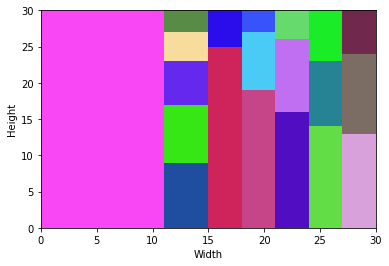


Paper dimensions: 31x31
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1439
mzn-stat: flatIntVars=623
mzn-stat: flatBoolConstraints=751
mzn-stat: flatIntConstraints=1935
mzn-stat: evaluatedReifiedConstraints=79
mzn-stat: evaluatedHalfReifiedConstraints=1749
mzn-stat: eliminatedImplications=455
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.237744
mzn-stat-end
mzn-stat: initTime=0.016983
mzn-stat: solveTime=0.007855
mzn-stat: solutions=1
mzn-stat: variables=2105
mzn-stat: propagators=2380
mzn-stat: propagations=32649
mzn-stat: nodes=483
mzn-stat: failures=237
mzn-stat: restarts=0
mzn-stat: peakDepth=35
mzn-stat-end
Solution: [[28, 28], [22, 27], [28, 23], [22, 21], [22, 14], [25, 23], [19, 22], [25, 13], [28, 12], [28

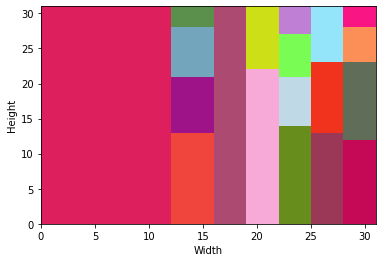


Paper dimensions: 32x32
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=3677
mzn-stat: flatIntVars=1704
mzn-stat: flatBoolConstraints=2111
mzn-stat: flatIntConstraints=5129
mzn-stat: evaluatedReifiedConstraints=185
mzn-stat: evaluatedHalfReifiedConstraints=4748
mzn-stat: eliminatedImplications=1424
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.460651
mzn-stat-end
mzn-stat: initTime=0.045179
mzn-stat: solveTime=0.060916
mzn-stat: solutions=1
mzn-stat: variables=5381
mzn-stat: propagators=7100
mzn-stat: propagations=141900
mzn-stat: nodes=2163
mzn-stat: failures=1075
mzn-stat: restarts=0
mzn-stat: peakDepth=90
mzn-stat-end
Solution: [[23, 29], [26, 28

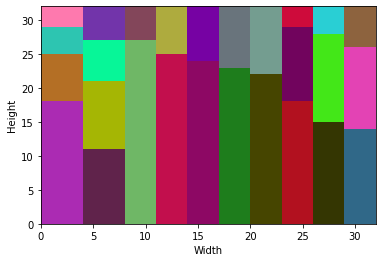


Paper dimensions: 33x33
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2204
mzn-stat: flatIntVars=902
mzn-stat: flatBoolConstraints=1127
mzn-stat: flatIntConstraints=2936
mzn-stat: evaluatedReifiedConstraints=118
mzn-stat: evaluatedHalfReifiedConstraints=2659
mzn-stat: eliminatedImplications=672
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.287904
mzn-stat-end
mzn-stat: initTime=0.026739
mzn-stat: solveTime=0.037413
mzn-stat: solutions=1
mzn-stat: variables=3117
mzn-stat: propagators=3811
mzn-stat: propagations=85086
mzn-stat: nodes=1544
mzn-stat: failures=766
mzn-stat: restarts=0
mzn-stat: peakDepth=67
mzn-stat-end
Solution: [[18, 30], [24, 29], [24, 24], [30, 27], [24, 17], [27, 

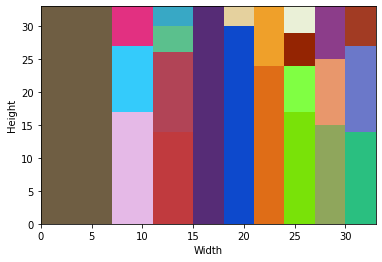


Paper dimensions: 34x34
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1989
mzn-stat: flatIntVars=909
mzn-stat: flatBoolConstraints=1106
mzn-stat: flatIntConstraints=2739
mzn-stat: evaluatedReifiedConstraints=106
mzn-stat: evaluatedHalfReifiedConstraints=2512
mzn-stat: eliminatedImplications=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.363298
mzn-stat-end
mzn-stat: initTime=0.029386
mzn-stat: solveTime=0.01479
mzn-stat: solutions=1
mzn-stat: variables=2941
mzn-stat: propagators=3481
mzn-stat: propagations=38591
mzn-stat: nodes=715
mzn-stat: failures=353
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[25, 31], [31, 30], [22, 29], [31, 24], [22, 22], [28, 26], [19, 25], [25

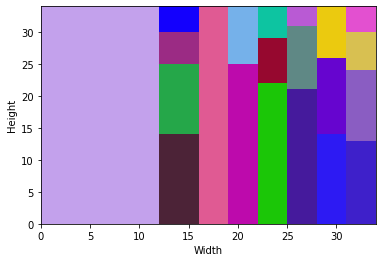


Paper dimensions: 35x35
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1550
mzn-stat: flatIntVars=521
mzn-stat: flatBoolConstraints=657
mzn-stat: flatIntConstraints=1942
mzn-stat: evaluatedReifiedConstraints=78
mzn-stat: evaluatedHalfReifiedConstraints=1709
mzn-stat: eliminatedImplications=300
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.222043
mzn-stat-end
mzn-stat: initTime=0.018968
mzn-stat: solveTime=0.061848
mzn-stat: solutions=1
mzn-stat: variables=2079
mzn-stat: propagators=2430
mzn-stat: propagations=108371
mzn-stat: nodes=2579
mzn-stat: failures=1283
mzn-stat: restarts=0
mzn-stat: peakDepth=61
mzn-stat-end
Solution: [[32, 32], [32, 28], [26, 30], [32, 22], [29, 28], [26, 22], [29, 1

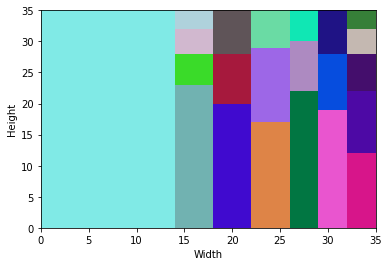


Paper dimensions: 36x36
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1785
mzn-stat: flatIntVars=719
mzn-stat: flatBoolConstraints=895
mzn-stat: flatIntConstraints=2357
mzn-stat: evaluatedReifiedConstraints=85
mzn-stat: evaluatedHalfReifiedConstraints=2154
mzn-stat: eliminatedImplications=525
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.26496
mzn-stat-end
mzn-stat: initTime=0.02124
mzn-stat: solveTime=0.031269
mzn-stat: solutions=1
mzn-stat: variables=2571
mzn-stat: propagators=2782
mzn-stat: propagations=72111
mzn-stat: nodes=1837
mzn-stat: failures=913
mzn-stat: restarts=0
mzn-stat: peakDepth=51
mzn-stat-end
Solution: [[33, 33], [24, 32], [27, 31], [27, 25], [33, 26], [24, 24]

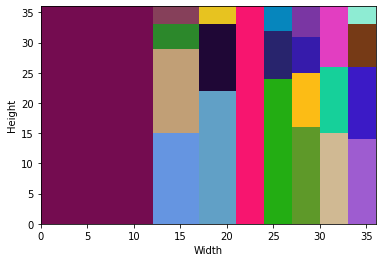


Paper dimensions: 37x37
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2111
mzn-stat: flatIntVars=652
mzn-stat: flatBoolConstraints=882
mzn-stat: flatIntConstraints=2607
mzn-stat: evaluatedReifiedConstraints=85
mzn-stat: evaluatedHalfReifiedConstraints=2362
mzn-stat: eliminatedImplications=406
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.25761
mzn-stat-end
mzn-stat: initTime=0.023099
mzn-stat: solveTime=0.055188
mzn-stat: solutions=1
mzn-stat: variables=2811
mzn-stat: propagators=3014
mzn-stat: propagations=121685
mzn-stat: nodes=2065
mzn-stat: failures=1027
mzn-stat: restarts=0
mzn-stat: peakDepth=54
mzn-stat-end
Solution: [[31, 34], [34, 33], [31

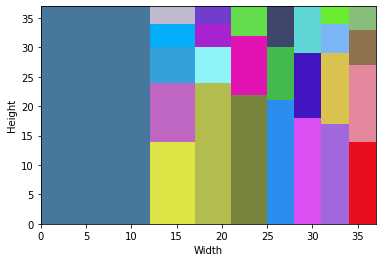


Paper dimensions: 38x38
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1022
mzn-stat: flatIntVars=335
mzn-stat: flatBoolConstraints=389
mzn-stat: flatIntConstraints=1266
mzn-stat: evaluatedReifiedConstraints=50
mzn-stat: evaluatedHalfReifiedConstraints=1082
mzn-stat: eliminatedImplications=146
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.182067
mzn-stat-end
mzn-stat: initTime=0.012176
mzn-stat: solveTime=0.037771
mzn-stat: solutions=1
mzn-stat: variables=1365
mzn-stat: propagators=1527
mzn-stat: propagations=96925
mzn-stat: nodes=2286
mzn-stat: failures=1137
mzn-stat: restarts=0
mzn-stat: peakDepth=69
mzn-stat-end
Solution: [[32, 35], [35, 34], [35, 29], [32, 29], [32, 22], [35, 21], [32, 13], [35, 11], [35, 0], [32

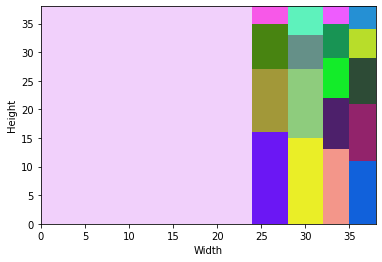


Paper dimensions: 39x39
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2157
mzn-stat: flatIntVars=525
mzn-stat: flatBoolConstraints=752
mzn-stat: flatIntConstraints=2540
mzn-stat: evaluatedReifiedConstraints=78
mzn-stat: evaluatedHalfReifiedConstraints=2257
mzn-stat: eliminatedImplications=234
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.24386
mzn-stat-end
mzn-stat: initTime=0.025332
mzn-stat: solveTime=0.182119
mzn-stat: solutions=1
mzn-stat: variables=2690
mzn-stat: propagators=3094
mzn-stat: propagations=351417
mzn-stat: nodes=5709
mzn-stat: failures=2846
mzn-stat: restarts=0
mzn-stat: peakDepth=118
mzn-stat-end
Solution: [[33, 36]

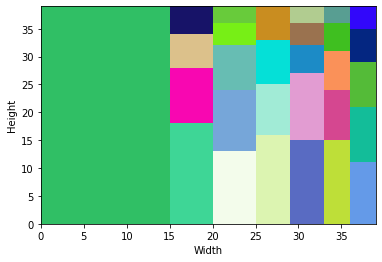


Paper dimensions: 40x40
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=931
mzn-stat: flatIntVars=322
mzn-stat: flatBoolConstraints=382
mzn-stat: flatIntConstraints=1156
mzn-stat: evaluatedReifiedConstraints=41
mzn-stat: evaluatedHalfReifiedConstraints=1024
mzn-stat: eliminatedImplications=165
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.178415
mzn-stat-end
mzn-stat: initTime=0.014676
mzn-stat: solveTime=0.008036
mzn-stat: solutions=1
mzn-stat: variables=1328
mzn-stat: propagators=1182
mzn-stat: propagations=25281
mzn-stat: nodes=596
mzn-stat: failures=294
mzn-stat: restarts=0
mzn-stat: peakDepth=37
mzn-stat-end
Solution: [[34, 37], [37, 36], [34, 32], [37, 30], [34, 25], [37, 22], [34, 16], [37, 12], [37, 0

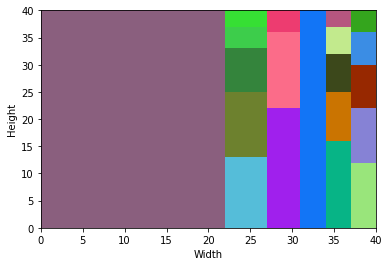


Instance size / Running time plot:


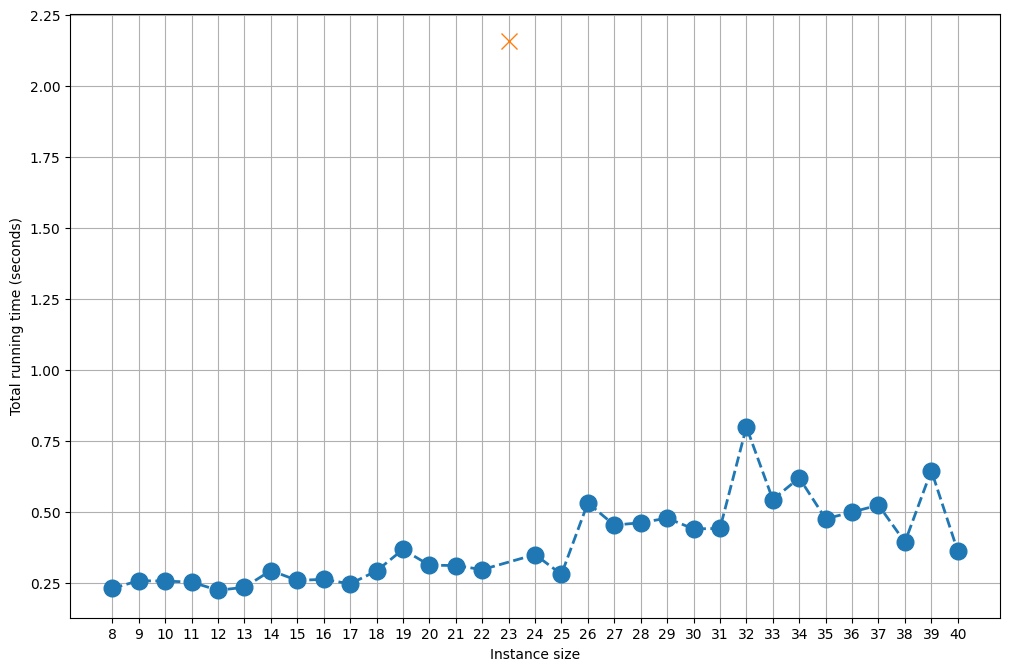

In [207]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    instances.append(i)
    current_instance = f"{i}x{i}"
    path = f"instances/{current_instance}.txt" 
    w_paper, h_paper, n, presents = read_input(path)
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    solutions = %minizinc -t $max_time -s pwp-v6
    end_time = time()
    times.append(end_time - start_time)
    if solutions:
        show_solutions(w_paper, h_paper, n, presents, solutions, model='cp')
    print()

if len(instances) > 1:
    print("Instance size / Running time plot:")
    show_running_times(instances, times, max_time=max_time, model='cp')

### First model 

In this first CP model we tried to put a single constraint, regarding rectangles overlapment. The constraint is implemented as a list of disjunctive comparisons and, because of that, running times of the whole model tend to be very high, starting from the smaller and easier instances.

In [88]:
%%mzn_model pwp-v1
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Variables
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;

% Constraints
% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Second model

In this second CP model we refactored the non-overlapping constraint by removing the disjuctive part and instead forcing all overlapping areas to be zero. Moreover, we introduced a new list of variables (`bl_corners_values`) which can be viewed as a linearization of the 2D coordinates associated with rectangles bottom left corners, since we wanted to add redundant constraints, to deal with values distribution inside the 2D space. In particular, we posed an `alldifferent` constraint over `bl_corners_values` and we forced a single rectangle to be located at `(0, 0)`.

In [93]:
%%mzn_model pwp-v2
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

% Channeling constraints
predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Third model

In this third model we tried to further reduce our variable's domains, by introducing a new list of variables (`tr_corners`), representing top right corners of each rectangle. The main achievement of this model is the introduction of the global constraint `diffn_k` to handle non-overlapment and of the global constrainst `cumulative` to maximally stack rectangles on each axis. Moreover, we used top right corners to force rectangles to stay inside the outer container.

In [97]:
%%mzn_model pwp-v3
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of 1..max_dim: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Search
solve satisfy;

### Fourth model

In this fourth model we tried to add different constraints, to possibly enhance running times:
* Redundant constraints:
    * Try and stack two presents having the same width s.t. their heights would sum to the total height 
    * Sum of all the areas of all the placed presents equal to total area
* Symmetry breaking constraints:
    * Presents in the same column ordered by width (which resulted in an overall slowdown)
    * Biggest rectangle contained in the lower-left quadrant (which didn't lead to any major improvement)

In [127]:
%%mzn_model pwp-v4
include "globals.mzn";

%Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Two presents sum to total height or width
constraint forall(i, j in ns where j > i) (
    presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j] == h_paper -> 
    bl_corners_ys[j] = presents_ys[i] /\ bl_corners_ys[i] = 0
);
constraint forall(i, j in ns where j > i) (
    presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j] == w_paper -> 
    bl_corners_xs[j] = presents_xs[i] /\ bl_corners_xs[i] = 0
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint 
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

/*
% Presents in the same column ordered by width
constraint forall(i, j in ns where j > i) (
    bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j] -> 
    bl_corners_ys[i] > bl_corners_ys[j]
);
*/

% Search
solve satisfy;

### Fifth model

In this fifth model we are generalizing the idea of stacking two rectangles of the same width with heights summing to the total height, to:
* Partition rectangles in groups representing different widths (`presents_group_xs`)
* Check whether all groups form one or more columns (predicate `is_col_stacking_feasible`)
    * If possible, assign each rectangle to a specific column and constrain the other rectangles to follow (predicate `stack_cols`)
    * If not possible, operate like in previous models

The predicate `stack_cols` works as follows:
* For each rectangle group
    * Find a feasible `bin_packing` over a pre-computed number of columns
    * For each rectangle in the same column (same bin), add a constraint to fix its bottom left corner

We also tried to combine our ad-hoc column stacking procedure with the approaches described below (_intervals_ and _anchor points_), without any luck.

In [98]:
%%mzn_model pwp-v5
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[int] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint not(col_stacking_feasible) ->
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

% Search
solve satisfy;

#### Intervals approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents an idea taken from the paper _New Improvements in Optimal Rectangle Packing (Eric Huang, Richard E. Korf)_, where domains associated with the x-coordinate of bottom left corners are reduced on the basis of a variable-sized interval:
> \[...\] a rectangle is assigned an interval of x-coordinates. Interval sizes are hand-picked for each rectangle prior to search, and they induce a smaller rectangle representing the common intersecting area of placing the rectangle in any location in the interval. \[...\] we assign all x-coordinates prior to any y-coordinates, and use interval variables for the x-coordinates. We set a rectangle’s interval size to 0.35 times its width, which gave us the best performance. Finally, we do not use interval variables for the y-coordinates.`

In [ ]:
% Constants
array[ns] of int: x_intervals_sizes = [ceil(presents_xs[i] * 0.35) | i in ns];

% Variables
array[ns, 1..2] of var 0..w_paper: x_intervals;

% Channeling constraints
predicate x_intervals_channeling(int: i) = 
    x_intervals[i, 2] == x_intervals[i, 1] + x_intervals_sizes[i] /\
    bl_corners_xs[i] >= x_intervals[i, 1] /\
    bl_corners_xs[i] <= x_intervals[i, 2];
constraint forall(i in ns) (x_intervals_channeling(i));

% Constraints
% Reduce corners domains based on x intervals
constraint forall(i, j in ns where j != i) (
    not(
        bl_corners_xs[j] < x_intervals[i, 2] + presents_xs[i] - x_intervals_sizes[i] /\ 
        bl_corners_xs[j] > x_intervals[i, 2] /\
        bl_corners_ys[j] >= bl_corners_ys[i] /\
        bl_corners_ys[j] < bl_corners_ys[i] + presents_ys[i]     
    )
);

% Search
solve :: seq_search([
    int_search(x_intervals, smallest, indomain_min),
    int_search(bl_corners_xs, smallest, indomain_min),
    int_search(bl_corners_ys, smallest, indomain_min)
]) satisfy;

#### Anchor points approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents a reduction on each present's domain, s.t. bottom left corners reside on corners of other rectangles or on the wrapping paper borders.

The main problem of this implementation was our inability of correctly expressing the constraint in an efficient way.

In [ ]:
% Variables
array[ns, 1..4] of var 0..coord_to_value(w_paper, h_paper): corners_values;

% Channeling constraints
predicate corners_values_channeling(int: i) = 
    corners_values[i, 1] == bl_corners_values[i] /\ 
    corners_values[i, 2] == coord_to_value(bl_corners_xs[i] + presents_xs[i], bl_corners_ys[i]) /\
    corners_values[i, 3] == coord_to_value(tr_corners[i, 1], tr_corners[i, 2]) /\
    corners_values[i, 4] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i] + presents_ys[i]);
constraint forall(i in ns) (corners_values_channeling(i));

% Constraints
% Corners anchor points
predicate anchor_points() = let {
        array[1..n * 4] of var int: lin_corners_values = array1d(1..n * 4, corners_values)
    } in
    nvalue(lin_corners_values) <= 2 * n + 2 /\ 
    count_eq(lin_corners_values, coord_to_value(0, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(0, w_paper), 1) /\
    count_eq(lin_corners_values, coord_to_value(h_paper, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(w_paper, h_paper), 1);
constraint anchor_points();

### Sixth model

In this sixth final model we are keeping the column stacking mechanism and introducing a new variables ordering (by decreasing rectangles areas) for symmetry breaking constraints and for a new search strategy. 

These adaptations were taken from _Implementation and Evaluation of a Sweep-Based Propagator for Diffn in Gecode (Mikael Östlund)_.

Moreover, we tried to implement another anchor points approach, which didn't work out as expected.

In [166]:
%%mzn_model pwp-v6
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of ns: order = sort_by(ns, [-areas[i] | i in ns]);
array[1..card(presents_xs_values)] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    array[1..n_presents] of 1..n_presents: positions = sort_by([j | j in 1..n_presents], [-weights[j] | j in 1..n_presents]);
    array[1..n_presents] of ns: ord_indexes = [indexes[j] | j in positions];
    array[1..n_presents] of 1..h_paper: ord_weights = [weights[j] | j in positions];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, ord_weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[ord_indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[ord_indexes[h]] == sum([ord_weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Non-optimal constraints
% Anchor points
/*
constraint forall(i in ns)(
    member([0] ++ [bl_corners_xs[j] + presents_xs[j] | j in ns where j != i], bl_corners_xs[i]) /\
    member([0] ++ [bl_corners_ys[j] + presents_ys[j] | j in ns where j != i], bl_corners_ys[i])
);
*/

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in not(col_stacking_feasible) ->
    lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Search
solve::
    if not(col_stacking_feasible) then
        seq_search([
            int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
            int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
        ])
    else int_search(bl_corners_values, dom_w_deg, indomain_min, complete)
    endif
satisfy;

### Seventh model (with rotation and same dimensions handling)

This model is dedicated to the implementation of the optional parts of the project, namely rotation and same dimensions handling.
About rotation, we removed the column stacking approach since presents dimensions are now considered as variables, and we introduced the global constraint `geost_bb` which can be used to find appropriate positions and rotations of the given rectangles without overlaps, by constraining them to be contained in a given bounding box. This approach obviously turned out to be much slower w.r.t. our sixth model. To get better results, we could try to find the minimum number of rotations needed to make column stacking feasible and proceed like before.
About rectangles with same dimensions, we simply included a symmetry breaking constraint accounting for pairwise positioning of equally-sized rectangles.

In [69]:
%%mzn_model pwp-v7
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: k = 2;
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: dim = 1..k;
set of int: ns = 1..n;
set of int: ns_rot = 1..2 * n;
array[dim] of int: l = [0, 0];
array[dim] of int: u = [w_paper, h_paper];
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of ns: order = sort_by(ns, [-areas[i] | i in ns]);
array[ns_rot, dim] of int: rect_size = array2d(ns_rot, dim, [get_rot(i, j, k)| i in ns, j, k in 0..1]);
array[ns_rot, dim] of int: rect_offset = array2d(ns_rot, dim, [0 | i in 1..4 * n]);
array[ns_rot] of set of ns_rot: shape = [{i}| i in ns_rot];
array[ns] of set of ns_rot: valid_shapes = [{i, i + 1}| i in ns_rot where i mod 2 != 0];

% Variables
array[ns, dim] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_dim: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var min_present_dim..max_present_dim: actual_presents_xs = [actual_dim(i, 1) | i in ns];
array[ns] of var min_present_dim..max_present_dim: actual_presents_ys = [actual_dim(i, 2) | i in ns];
array[ns] of var ns_rot: kind;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else -1 endif;
function int: get_dim(int: ind, int: axis) = if axis == 0 then presents_xs[ind] elseif axis == 1 then presents_ys[ind] else -1 endif;
function int: get_rot(int: ind, int: axis, int: rot) = if rot == 0 then get_dim(ind, axis) elseif rot == 1 then get_dim(ind, 1 - axis) else -1 endif;
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: actual_dim(int: ind, int: axis) = if kind[ind] mod 2 == 0 then presents[ind, other_axis(axis)] else presents[ind, axis] endif;

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + actual_presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + actual_presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Presents cannot overlap
constraint diffn(bl_corners_xs, bl_corners_ys, actual_presents_xs, actual_presents_ys);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, actual_presents_xs, actual_presents_ys, h_paper);
constraint cumulative(bl_corners_ys, actual_presents_ys, actual_presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - actual_presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - actual_presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= actual_presents_xs[i] /\ 
    tr_corners[i, 2] >= actual_presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Rectangles must have valid shapes
constraint forall (obj in ns) (kind[obj] in valid_shapes[obj]);

% Non-overlap, bounding box, rotation handling 
constraint geost_bb(k, rect_size, rect_offset, shape, bl_corners, kind, l, u);

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Rectangles with same dimensions handling
constraint forall(i in ns)(
    let {
        array[int] of int: same_dim_ind = [j | j in ns where presents_xs[j] = presents_xs[i] /\ presents_ys[j] = presents_ys[i]]
    } in 
        if length(same_dim_ind) > 1 /\ min(same_dim_ind) = i then
            forall(j in index_set(same_dim_ind) where j > 1) (
                lex_less(
                    [bl_corners_ys[same_dim_ind[j - 1]], bl_corners_xs[same_dim_ind[j - 1]]], 
                    [bl_corners_ys[same_dim_ind[j]], bl_corners_xs[same_dim_ind[j]]]
                )
            )
        else true 
        endif
);

% Search
solve:: seq_search([
    int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
    int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
]) satisfy;

## SMT

### Functions

In [185]:
def member(x, l):
    '''
    Return a contraint computing membership testing
    '''
    return Or([x == l[i] for i in range(len(l))])

def z3_max_list(l):
    '''
    Return a constraint computing the maximum over a list of variables
    '''
    c = []
    max_value = Int(rand_str())
    c.append(member(max_value, l))
    for i in range(len(l)):
        c.append(max_value >= l[i])
    return max_value, c

def z3_max(x, y):
    '''
    Return a constraint computing the maximum of two variables
    '''
    return If(x > y, x, y)

def z3_min_list(l):
    '''
    Return a constraint computing the minimum over a list of variables
    '''
    c = []
    min_value = Int(rand_str())
    c.append(member(min_value, l))
    for i in range(len(l)):
        c.append(min_value <= l[i])
    return min_value, c

def z3_min(x, y):
    '''
    Return a constraint computing the minimum of two variables
    '''
    return If(x < y, x, y)

def z3_bool2int(v):
    '''
    Convert a boolean variable to an integer one
    '''
    return IntSort().cast(v)

def z3_diffn(x, y, dx, dy):
    '''
    Return a list of constraints computing non-overlapping checks
    '''
    c = []
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            c.append(
                And(Or([
                    x[i] + dx[i] <= x[j],
                    y[i] + dy[i] <= y[j],
                    x[j] + dx[j] <= x[i],
                    y[j] + dy[j] <= y[i]
                ]))
            )
    return c

def z3_alldifferent_mat(l, s):
    '''
    Return a list of constraints computing all different checks
    '''
    assert(s > 1)
    
    c = []
    n = len(l)
    for i in range(n):
        for j in range(i + 1, n):
            disjunction = []
            for k in range(s):
                disjunction.append(l[i][k] != l[j][k])
            c.append(Or(disjunction))
    return c

def z3_cumulative(s, d, r, b, ls, us):
    '''
    Return a list of constraints computing cumulative checks.
    Here, resources `r`, durations `d` and bound `b` must be fixed
    '''
    c = []
    early = ls
    late = us + max(d)
    tasks = [i for i in range(len(s)) if r[i] > 0 and d[i] > 0]
    if late - early > 5000:
        for i in tasks:
            c1 = []
            for j in tasks:
                if j != i:
                    c1.append(z3_bool2int(And(s[j] <= s[i], s[i] < s[j] + d[j])) * r[j])
            c.append(b >= r[i] + Sum(c1))
    else:
        for t in range(early, late + 1):
            for i in tasks:
                c.append(
                    Sum([(If(s[i] <= t, 1, 0) * If(t < s[i] + d[i], 1, 0)) * r[i] for i in tasks]) <= b
                )
    return c

### Input

In [209]:
instance = None
min_instance, max_instance = 8, 40
max_time = 300 * 1000 # milliseconds

Paper dimensions: 8x8
Presents dimensions: [[3, 3], [3, 5], [5, 3], [5, 5]]
(:added-eqs                 40
 :arith-assert-diseq        22
 :arith-assert-lower        35
 :arith-assert-upper        31
 :arith-bound-prop          53
 :arith-eq-adapter          28
 :arith-fixed-eqs           4
 :arith-num-rows            12
 :arith-offset-eqs          10
 :arith-pivots              2
 :arith-row-summations      4
 :arith-tableau-max-columns 21
 :arith-tableau-max-rows    12
 :binary-propagations       60
 :conflicts                 1
 :decisions                 5
 :del-clause                4
 :final-checks              1
 :max-memory                121.73
 :memory                    63.26
 :mk-bool-var               122
 :mk-clause                 82
 :num-allocs                72535055
 :num-checks                1
 :propagations              83
 :rlimit-count              73743804904.00)
Total running time: 0.094 seconds
Solution: [[5, 0], [0, 3], [0, 0], [3, 3]]


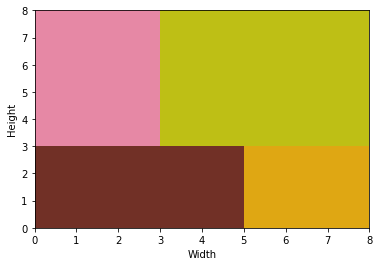


Paper dimensions: 9x9
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]
(:added-eqs                 66
 :arith-assert-diseq        55
 :arith-assert-lower        80
 :arith-assert-upper        67
 :arith-bound-prop          80
 :arith-conflicts           6
 :arith-eq-adapter          39
 :arith-fixed-eqs           3
 :arith-num-rows            20
 :arith-offset-eqs          23
 :arith-pivots              22
 :arith-row-summations      95
 :arith-tableau-max-columns 31
 :arith-tableau-max-rows    20
 :binary-propagations       121
 :conflicts                 7
 :decisions                 19
 :del-clause                16
 :final-checks              1
 :max-memory                121.73
 :memory                    63.25
 :mk-bool-var               173
 :mk-clause                 127
 :num-allocs                72572574
 :num-checks                1
 :propagations              171
 :rlimit-count              73743816306.00)
Total running time: 0.057 seconds
Solution: [[0, 6], 

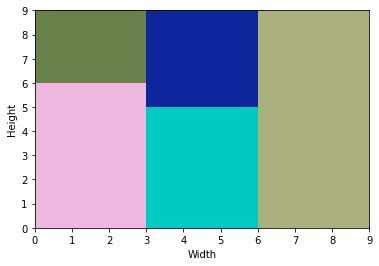


Paper dimensions: 10x10
Presents dimensions: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]
(:added-eqs                 143
 :arith-assert-diseq        109
 :arith-assert-lower        111
 :arith-assert-upper        147
 :arith-bound-prop          176
 :arith-conflicts           9
 :arith-eq-adapter          54
 :arith-fixed-eqs           7
 :arith-num-rows            30
 :arith-offset-eqs          54
 :arith-pivots              17
 :arith-row-summations      90
 :arith-tableau-max-columns 43
 :arith-tableau-max-rows    30
 :binary-propagations       212
 :conflicts                 12
 :decisions                 51
 :del-clause                10
 :final-checks              1
 :max-memory                121.73
 :memory                    63.26
 :minimized-lits            1
 :mk-bool-var               240
 :mk-clause                 247
 :num-allocs                72611715
 :num-checks                1
 :propagations              329
 :rlimit-count              73743831893.00)
Total r

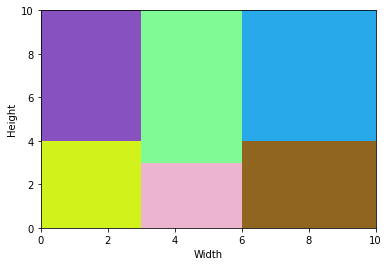


Paper dimensions: 11x11
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]
(:added-eqs                 312
 :arith-assert-diseq        408
 :arith-assert-lower        379
 :arith-assert-upper        544
 :arith-bound-prop          342
 :arith-conflicts           29
 :arith-eq-adapter          70
 :arith-fixed-eqs           15
 :arith-num-rows            42
 :arith-offset-eqs          105
 :arith-pivots              87
 :arith-row-summations      681
 :arith-tableau-max-columns 57
 :arith-tableau-max-rows    42
 :binary-propagations       878
 :conflicts                 38
 :decisions                 233
 :del-clause                4
 :final-checks              1
 :max-memory                121.73
 :memory                    63.27
 :minimized-lits            15
 :mk-bool-var               314
 :mk-clause                 459
 :num-allocs                72653111
 :num-checks                1
 :propagations              1666
 :rlimit-count              737438667

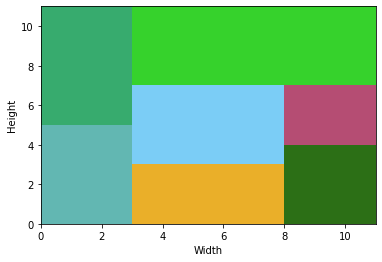


Paper dimensions: 12x12
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]
(:added-eqs                 518
 :arith-assert-diseq        709
 :arith-assert-lower        923
 :arith-assert-upper        966
 :arith-bound-prop          638
 :arith-conflicts           76
 :arith-eq-adapter          88
 :arith-fixed-eqs           61
 :arith-num-rows            56
 :arith-offset-eqs          132
 :arith-pivots              336
 :arith-row-summations      3404
 :arith-tableau-max-columns 73
 :arith-tableau-max-rows    56
 :binary-propagations       1663
 :conflicts                 93
 :decisions                 274
 :del-clause                18
 :final-checks              1
 :max-memory                121.73
 :memory                    63.27
 :minimized-lits            74
 :mk-bool-var               398
 :mk-clause                 833
 :num-allocs                72696961
 :num-checks                1
 :propagations              3209
 :rlimit-count           

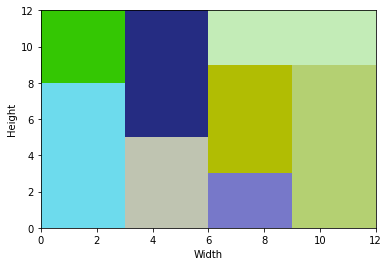


Paper dimensions: 13x13
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]
(:added-eqs                 2996
 :arith-assert-diseq        4137
 :arith-assert-lower        5273
 :arith-assert-upper        4857
 :arith-bound-prop          1383
 :arith-conflicts           210
 :arith-eq-adapter          108
 :arith-fixed-eqs           168
 :arith-num-rows            72
 :arith-offset-eqs          1090
 :arith-pivots              1107
 :arith-row-summations      12078
 :arith-tableau-max-columns 91
 :arith-tableau-max-rows    72
 :binary-propagations       11486
 :conflicts                 350
 :decisions                 1082
 :del-clause                6
 :final-checks              1
 :max-memory                121.73
 :memory                    63.27
 :minimized-lits            600
 :mk-bool-var               492
 :mk-clause                 1861
 :num-allocs                72744022
 :num-checks                1
 :propagations              27172
 

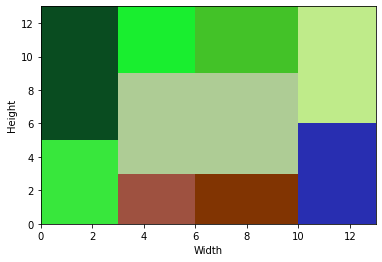


Paper dimensions: 14x14
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]
(:added-eqs                 1861
 :arith-assert-diseq        2387
 :arith-assert-lower        2816
 :arith-assert-upper        3305
 :arith-bound-prop          1030
 :arith-conflicts           179
 :arith-eq-adapter          108
 :arith-fixed-eqs           151
 :arith-num-rows            72
 :arith-offset-eqs          722
 :arith-pivots              778
 :arith-row-summations      9141
 :arith-tableau-max-columns 91
 :arith-tableau-max-rows    72
 :binary-propagations       5984
 :conflicts                 233
 :decisions                 742
 :del-clause                18
 :final-checks              1
 :max-memory                121.73
 :memory                    63.27
 :minimized-lits            191
 :mk-bool-var               492
 :mk-clause                 1391
 :num-allocs                72790791
 :num-checks                1
 :propagations              13137
 :re

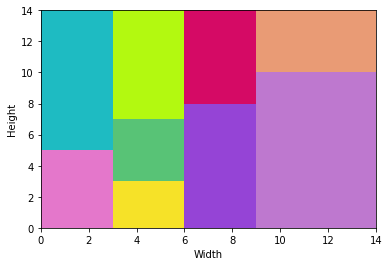


Paper dimensions: 15x15
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]
(:added-eqs                 1700
 :arith-assert-diseq        2534
 :arith-assert-lower        3076
 :arith-assert-upper        3206
 :arith-bound-prop          1336
 :arith-conflicts           185
 :arith-eq-adapter          129
 :arith-fixed-eqs           106
 :arith-num-rows            90
 :arith-offset-eqs          598
 :arith-pivots              795
 :arith-row-summations      11588
 :arith-tableau-max-columns 111
 :arith-tableau-max-rows    90
 :binary-propagations       6177
 :conflicts                 229
 :decisions                 1009
 :del-clause                43
 :final-checks              1
 :max-memory                121.73
 :memory                    63.27
 :minimized-lits            116
 :mk-bool-var               593
 :mk-clause                 1720
 :num-allocs                72840359
 :num-checks                1
 :propagations            

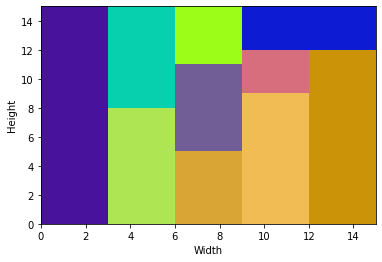


Paper dimensions: 16x16
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]
(:added-eqs                 5535
 :arith-assert-diseq        6612
 :arith-assert-lower        8288
 :arith-assert-upper        8453
 :arith-bound-prop          2286
 :arith-conflicts           359
 :arith-eq-adapter          130
 :arith-fixed-eqs           412
 :arith-num-rows            90
 :arith-offset-eqs          1922
 :arith-pivots              1880
 :arith-row-summations      24998
 :arith-tableau-max-columns 111
 :arith-tableau-max-rows    90
 :binary-propagations       18305
 :conflicts                 551
 :decisions                 1819
 :del-clause                24
 :final-checks              1
 :max-memory                121.73
 :memory                    63.28
 :minimized-lits            1057
 :mk-bool-var               596
 :mk-clause                 2994
 :num-allocs                72891055
 :num-checks                1
 :propagations        

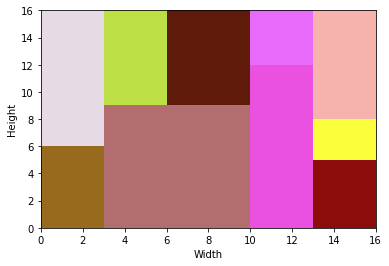


Paper dimensions: 17x17
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]
(:added-eqs                 11341
 :arith-assert-diseq        12982
 :arith-assert-lower        17472
 :arith-assert-upper        15629
 :arith-bound-prop          4121
 :arith-conflicts           576
 :arith-eq-adapter          180
 :arith-fixed-eqs           1015
 :arith-num-rows            132
 :arith-offset-eqs          4245
 :arith-pivots              2894
 :arith-row-summations      48928
 :arith-tableau-max-columns 157
 :arith-tableau-max-rows    132
 :binary-propagations       31783
 :conflicts                 840
 :decisions                 4114
 :del-clause                16
 :final-checks              1
 :max-memory                121.73
 :memory                    63.30
 :minimized-lits            1583
 :mk-bool-var               834
 :mk-clause                 5185
 :num-allocs                72949161
 :num-checks                1


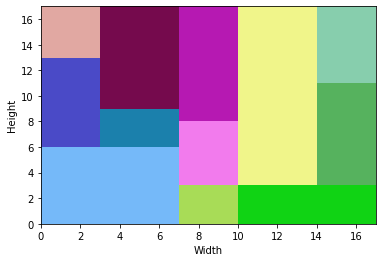


Paper dimensions: 18x18
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]
(:added-eqs                 466201
 :arith-assert-diseq        1311697
 :arith-assert-lower        2072976
 :arith-assert-upper        1993460
 :arith-bound-prop          162415
 :arith-conflicts           32902
 :arith-eq-adapter          912
 :arith-fixed-eqs           24658
 :arith-num-rows            720
 :arith-offset-eqs          169217
 :arith-pivots              307743
 :arith-row-summations      7954638
 :arith-tableau-max-columns 819
 :arith-tableau-max-rows    720
 :binary-propagations       3541180
 :conflicts                 72398
 :decisions                 214466
 :del-clause                23888
 :final-checks              1
 :max-memory                121.73
 :memory                    63.31
 :minimized-lits            261989
 :mk-bool-var               4280
 :mk-clause                 235840
 :

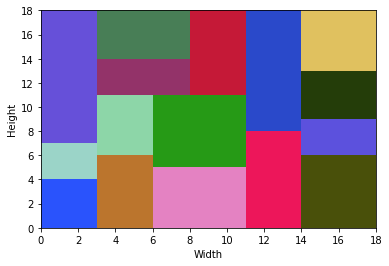


Paper dimensions: 19x19
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]
(:added-eqs                 83607
 :arith-assert-diseq        177470
 :arith-assert-lower        228144
 :arith-assert-upper        222953
 :arith-bound-prop          23196
 :arith-conflicts           8208
 :arith-eq-adapter          237
 :arith-fixed-eqs           6485
 :arith-num-rows            182
 :arith-offset-eqs          31897
 :arith-pivots              52509
 :arith-row-summations      1236660
 :arith-tableau-max-columns 211
 :arith-tableau-max-rows    182
 :binary-propagations       479281
 :conflicts                 13523
 :decisions                 38547
 :del-clause                1652
 :final-checks              1
 :max-memory                121.73
 :memory                    63.31
 :minimized-lits            23230
 :mk-bool-var               1109
 :mk-clause                 37020
 :num-allocs                73

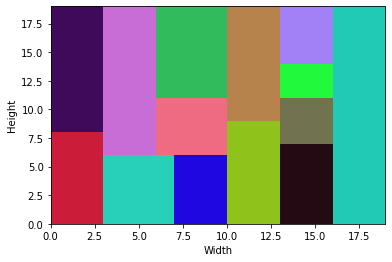


Paper dimensions: 20x20
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]
(:added-eqs                 9411
 :arith-assert-diseq        11957
 :arith-assert-lower        14422
 :arith-assert-upper        16140
 :arith-bound-prop          4311
 :arith-conflicts           436
 :arith-eq-adapter          238
 :arith-fixed-eqs           810
 :arith-num-rows            182
 :arith-offset-eqs          3602
 :arith-pivots              2356
 :arith-row-summations      50198
 :arith-tableau-max-columns 211
 :arith-tableau-max-rows    182
 :binary-propagations       32490
 :conflicts                 656
 :decisions                 4365
 :del-clause                48
 :final-checks              1
 :max-memory                121.73
 :memory                    63.31
 :minimized-lits            919
 :mk-bool-var               1112
 :mk-clause                 5270
 :num-allocs                73242679
 :num-checks

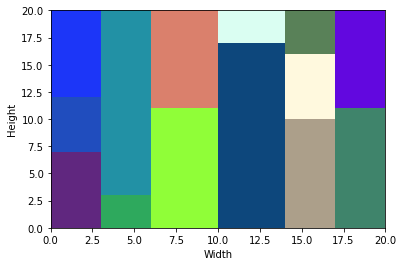


Paper dimensions: 21x21
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]
(:added-eqs                 21430
 :arith-assert-diseq        39611
 :arith-assert-lower        51854
 :arith-assert-upper        48301
 :arith-bound-prop          10554
 :arith-conflicts           1647
 :arith-eq-adapter          270
 :arith-fixed-eqs           1673
 :arith-num-rows            210
 :arith-offset-eqs          8310
 :arith-pivots              10244
 :arith-row-summations      261733
 :arith-tableau-max-columns 241
 :arith-tableau-max-rows    210
 :binary-propagations       108673
 :conflicts                 2502
 :decisions                 12949
 :del-clause                46
 :final-checks              1
 :max-memory                121.73
 :memory                    63.31
 :minimized-lits            3827
 :mk-bool-var               1266
 :mk-clause                 13403
 :num-allocs                73

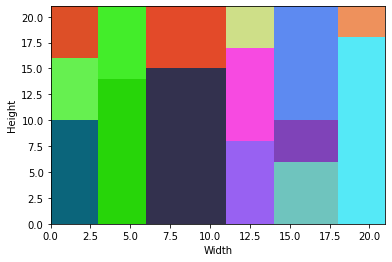


Paper dimensions: 22x22
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]
(:added-eqs                 51866
 :arith-assert-diseq        91199
 :arith-assert-lower        118684
 :arith-assert-upper        111316
 :arith-bound-prop          16044
 :arith-conflicts           3030
 :arith-eq-adapter          303
 :arith-fixed-eqs           4588
 :arith-num-rows            240
 :arith-offset-eqs          21259
 :arith-pivots              18488
 :arith-row-summations      502206
 :arith-tableau-max-columns 273
 :arith-tableau-max-rows    240
 :binary-propagations       243488
 :conflicts                 4699
 :decisions                 24443
 :del-clause                87
 :final-checks              1
 :max-memory                121.73
 :memory                    63.31
 :minimized-lits            8744
 :mk-bool-var               1427
 :mk-clause                 21135
 :num-allocs     

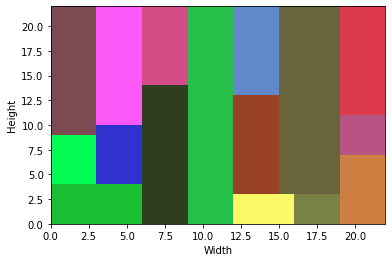


Paper dimensions: 23x23
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]
(:added-eqs                 1056790
 :arith-assert-diseq        2469586
 :arith-assert-lower        3668407
 :arith-assert-upper        3452155
 :arith-bound-prop          260493
 :arith-conflicts           67242
 :arith-eq-adapter          1254
 :arith-fixed-eqs           61802
 :arith-num-rows            1026
 :arith-offset-eqs          430882
 :arith-pivots              548799
 :arith-row-summations      19596266
 :arith-tableau-max-columns 1143
 :arith-tableau-max-rows    1026
 :binary-propagations       6528644
 :conflicts                 131110
 :dd-assertions             64010
 :dd-propagations           815990
 :decisions                 446069
 :del-clause                69041
 :final-checks              1
 :max-memory                121.73
 :memory                    63.37

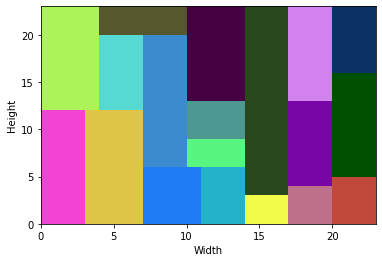


Paper dimensions: 24x24
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]
(:added-eqs                 332104
 :arith-assert-diseq        692517
 :arith-assert-lower        966941
 :arith-assert-upper        924892
 :arith-bound-prop          86465
 :arith-conflicts           20403
 :arith-eq-adapter          754
 :arith-fixed-eqs           25565
 :arith-num-rows            612
 :arith-offset-eqs          135013
 :arith-pivots              149679
 :arith-row-summations      4979392
 :arith-tableau-max-columns 686
 :arith-tableau-max-rows    612
 :binary-propagations       1833285
 :conflicts                 33324
 :decisions                 135822
 :del-clause                5583
 :final-checks              1
 :max-memory                121.73
 :memory                    63.36
 :minimized-lits            65711
 :mk-bool-var               3565
 :mk-clause           

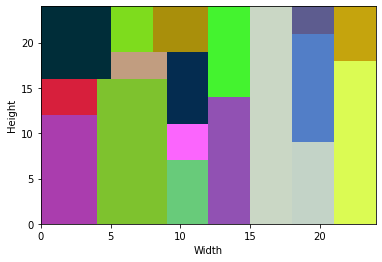


Paper dimensions: 25x25
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]
(:added-eqs                 531992
 :arith-assert-diseq        1518942
 :arith-assert-lower        2353829
 :arith-assert-upper        2251345
 :arith-bound-prop          170543
 :arith-conflicts           43265
 :arith-eq-adapter          1251
 :arith-fixed-eqs           28937
 :arith-num-rows            1026
 :arith-offset-eqs          230874
 :arith-pivots              338039
 :arith-row-summations      12528949
 :arith-tableau-max-columns 1143
 :arith-tableau-max-rows    1026
 :binary-propagations       3590087
 :conflicts                 66139
 :decisions                 281154
 :del-clause                35746
 :final-checks              1
 :max-memory                121.73
 :memory                    63.37
 :minimized-lits            100783
 :mk-bool-var               5927
 

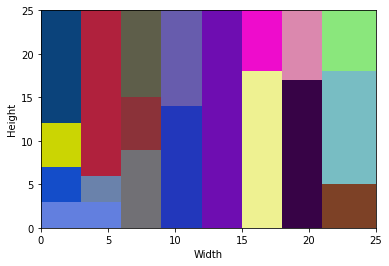


Paper dimensions: 26x26
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]
(:added-eqs                 1021155
 :arith-assert-diseq        2594312
 :arith-assert-lower        3883326
 :arith-assert-upper        3653599
 :arith-bound-prop          294251
 :arith-conflicts           62797
 :arith-eq-adapter          1650
 :arith-fixed-eqs           57376
 :arith-num-rows            1386
 :arith-offset-eqs          440547
 :arith-pivots              519064
 :arith-row-summations      22991358
 :arith-tableau-max-columns 1521
 :arith-tableau-max-rows    1386
 :binary-propagations       6811993
 :conflicts                 116800
 :dd-assertions             65277
 :dd-propagations           880202
 :decisions                 488448
 :del-clause                56976
 :final-checks              1
 :max-memory                121.73
 :memor

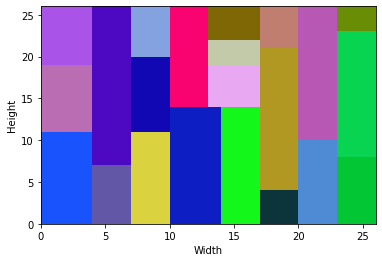


Paper dimensions: 27x27
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]
(:added-eqs                 929924
 :arith-assert-diseq        2066959
 :arith-assert-lower        3194546
 :arith-assert-upper        3003486
 :arith-bound-prop          231416
 :arith-conflicts           51429
 :arith-eq-adapter          1512
 :arith-fixed-eqs           65192
 :arith-num-rows            1260
 :arith-offset-eqs          387800
 :arith-pivots              407410
 :arith-row-summations      17338578
 :arith-tableau-max-columns 1389
 :arith-tableau-max-rows    1260
 :binary-propagations       5223653
 :conflicts                 81871
 :decisions                 375882
 :del-clause                36440
 :final-checks              1
 :max-memory                121.73
 :memory                    63.37
 :minimized-lits            155520
 :mk-bool-var     

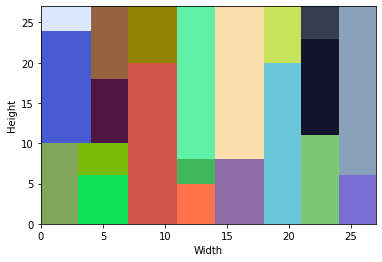


Paper dimensions: 28x28
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]
(:added-eqs                 914687
 :arith-assert-diseq        2575780
 :arith-assert-lower        3766747
 :arith-assert-upper        3611761
 :arith-bound-prop          292899
 :arith-conflicts           70111
 :arith-eq-adapter          1650
 :arith-fixed-eqs           48938
 :arith-num-rows            1386
 :arith-offset-eqs          390655
 :arith-pivots              560042
 :arith-row-summations      25670464
 :arith-tableau-max-columns 1521
 :arith-tableau-max-rows    1386
 :binary-propagations       6585454
 :conflicts                 118310
 :dd-assertions             84706
 :dd-propagations           1129368
 :decisions                 532815
 :del-clause                105382
 :final-checks              1
 :max-memory                121.73
 :memor

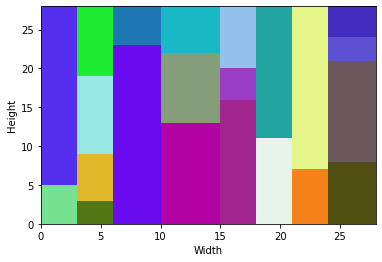


Paper dimensions: 29x29
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]
(:added-eqs                 891629
 :arith-assert-diseq        2557074
 :arith-assert-lower        3802199
 :arith-assert-upper        3546009
 :arith-bound-prop          337197
 :arith-conflicts           55484
 :arith-eq-adapter          1944
 :arith-fixed-eqs           46996
 :arith-num-rows            1656
 :arith-offset-eqs          393712
 :arith-pivots              495983
 :arith-row-summations      24229804
 :arith-tableau-max-columns 1803
 :arith-tableau-max-rows    1656
 :binary-propagations       8488877
 :conflicts                 1266065
 :dd-assertions             18174980
 :dd-propagations           207500881
 :decisions                 2550210
 :del-clause                1178027
 :final-checks              1
 :max-memory      

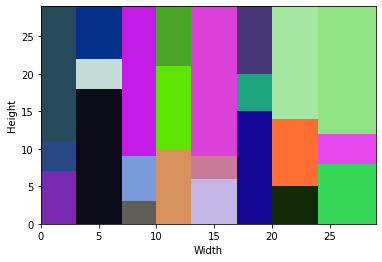


Paper dimensions: 30x30
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]
(:added-eqs                 978728
 :arith-assert-diseq        2757547
 :arith-assert-lower        3919043
 :arith-assert-upper        3709848
 :arith-bound-prop          277281
 :arith-conflicts           67491
 :arith-eq-adapter          1377
 :arith-fixed-eqs           50606
 :arith-num-rows            1140
 :arith-offset-eqs          433963
 :arith-pivots              567904
 :arith-row-summations      21385634
 :arith-tableau-max-columns 1263
 :arith-tableau-max-rows    1140
 :binary-propagations       7358388
 :conflicts                 134794
 :dd-assertions             55280
 :dd-propagations           686531
 :decisions                 526955
 :del-clause                92619
 :final-checks              1
 :max-memory                121.73
 :memory                 

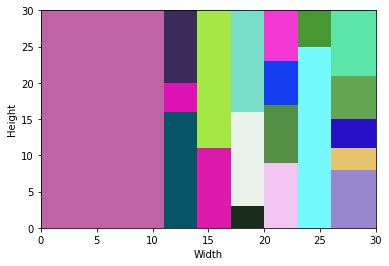


Paper dimensions: 31x31
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]
(:added-eqs                 312761
 :arith-assert-diseq        959907
 :arith-assert-lower        1385736
 :arith-assert-upper        1347248
 :arith-bound-prop          118843
 :arith-conflicts           24183
 :arith-eq-adapter          832
 :arith-fixed-eqs           17748
 :arith-num-rows            684
 :arith-offset-eqs          127430
 :arith-pivots              190478
 :arith-row-summations      6648382
 :arith-tableau-max-columns 762
 :arith-tableau-max-rows    684
 :binary-propagations       2308257
 :conflicts                 38594
 :decisions                 183313
 :del-clause                12382
 :final-checks              1
 :max-memory                121.73
 :memory                    63.37
 :minimized-lits            80967
 :mk-bool-var               3947
 :mk-cl

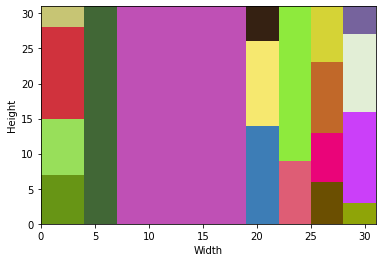


Paper dimensions: 32x32
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]
(:added-eqs                 763467
 :arith-assert-diseq        2721589
 :arith-assert-lower        3993810
 :arith-assert-upper        3834056
 :arith-bound-prop          370270
 :arith-conflicts           49301
 :arith-eq-adapter          2430
 :arith-fixed-eqs           50420
 :arith-num-rows            2106
 :arith-offset-eqs          328917
 :arith-pivots              386340
 :arith-row-summations      23681686
 :arith-tableau-max-columns 2271
 :arith-tableau-max-rows    2106
 :binary-propagations       7407346
 :conflicts                 538811
 :dd-assertions             9403103
 :dd-propagations           106670895
 :decisions                 1415370
 :del-clause                467163
 :final-checks       

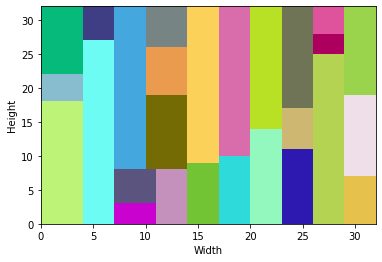


Paper dimensions: 33x33
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]
(:added-eqs                 768621
 :arith-assert-diseq        2690534
 :arith-assert-lower        3759117
 :arith-assert-upper        3611453
 :arith-bound-prop          297921
 :arith-conflicts           61023
 :arith-eq-adapter          1788
 :arith-fixed-eqs           42775
 :arith-num-rows            1518
 :arith-offset-eqs          342163
 :arith-pivots              457061
 :arith-row-summations      22177396
 :arith-tableau-max-columns 1659
 :arith-tableau-max-rows    1518
 :binary-propagations       6389111
 :conflicts                 99434
 :dd-assertions             108933
 :dd-propagations           1361703
 :decisions                 615627
 :del-clause                50247
 :final-checks              1
 :max-memory                121

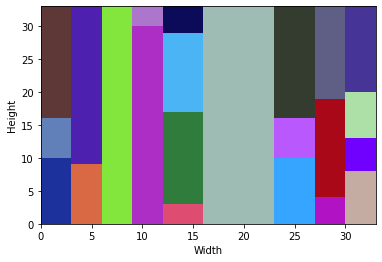


Paper dimensions: 34x34
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]
(:added-eqs                 426179
 :arith-assert-diseq        1461700
 :arith-assert-lower        2189479
 :arith-assert-upper        2082030
 :arith-bound-prop          188024
 :arith-conflicts           32408
 :arith-eq-adapter          1506
 :arith-fixed-eqs           23374
 :arith-num-rows            1260
 :arith-offset-eqs          181984
 :arith-pivots              258045
 :arith-row-summations      10759015
 :arith-tableau-max-columns 1389
 :arith-tableau-max-rows    1260
 :binary-propagations       3207953
 :conflicts                 45776
 :decisions                 304650
 :del-clause                28020
 :final-checks              1
 :max-memory                121.73
 :memory                    63.56
 :minimized-lits            58417
 :mk-bool-var  

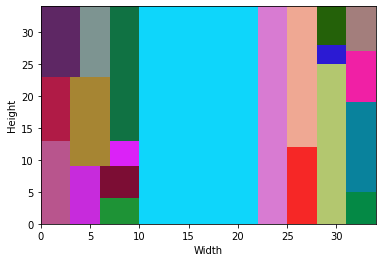


Paper dimensions: 35x35
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]
(:added-eqs                 899096
 :arith-assert-diseq        2511381
 :arith-assert-lower        3613016
 :arith-assert-upper        3330979
 :arith-bound-prop          307611
 :arith-conflicts           57896
 :arith-eq-adapter          1647
 :arith-fixed-eqs           45879
 :arith-num-rows            1386
 :arith-offset-eqs          409939
 :arith-pivots              477458
 :arith-row-summations      20381416
 :arith-tableau-max-columns 1521
 :arith-tableau-max-rows    1386
 :binary-propagations       6377792
 :conflicts                 104661
 :dd-assertions             83762
 :dd-propagations           1103503
 :decisions                 509744
 :del-clause                59870
 :final-checks              1
 :max-memory                121.73
 :memor

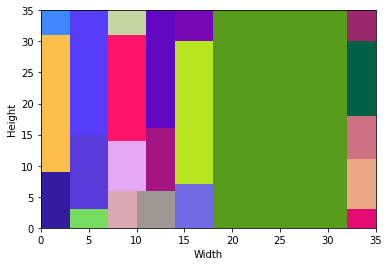


Paper dimensions: 36x36
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]
(:added-eqs                 441906
 :arith-assert-diseq        1660724
 :arith-assert-lower        2418549
 :arith-assert-upper        2296055
 :arith-bound-prop          230557
 :arith-conflicts           34420
 :arith-eq-adapter          1788
 :arith-fixed-eqs           21693
 :arith-num-rows            1518
 :arith-offset-eqs          197262
 :arith-pivots              280357
 :arith-row-summations      13273373
 :arith-tableau-max-columns 1659
 :arith-tableau-max-rows    1518
 :binary-propagations       3659020
 :conflicts                 49535
 :decisions                 372144
 :del-clause                23766
 :final-checks              1
 :max-memory                121.73
 :memory                    63.57
 :minimized-lits            6069

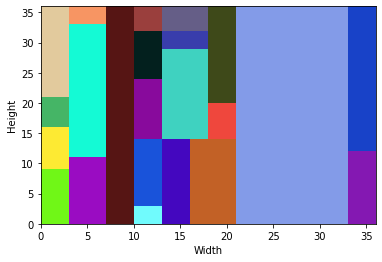


Paper dimensions: 37x37
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]
(:added-eqs                 713228
 :arith-assert-diseq        2538351
 :arith-assert-lower        3583027
 :arith-assert-upper        3463524
 :arith-bound-prop          398537
 :arith-conflicts           45479
 :arith-eq-adapter          2427
 :arith-fixed-eqs           36883
 :arith-num-rows            2106
 :arith-offset-eqs          336611
 :arith-pivots              358718
 :arith-row-summations      20943951
 :arith-tableau-max-columns 2271
 :arith-tableau-max-rows    2106
 :binary-propagations       8921450
 :conflicts                 2306233
 :dd-assertions             36152352
 :dd-propagations           452371741
 :decisions                 4454795
 :del-clause                2222657
 :final-checks     

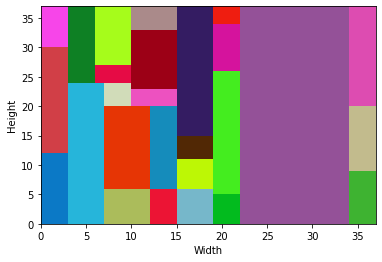


Paper dimensions: 38x38
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]
(:added-eqs                 29445
 :arith-assert-diseq        112007
 :arith-assert-lower        134233
 :arith-assert-upper        129207
 :arith-bound-prop          22909
 :arith-conflicts           2716
 :arith-eq-adapter          417
 :arith-fixed-eqs           1401
 :arith-num-rows            342
 :arith-offset-eqs          12879
 :arith-pivots              15211
 :arith-row-summations      555431
 :arith-tableau-max-columns 381
 :arith-tableau-max-rows    342
 :binary-propagations       245922
 :conflicts                 3260
 :decisions                 46749
 :del-clause                54
 :final-checks              1
 :max-memory                121.73
 :memory                    63.55
 :minimized-lits            1133
 :mk-bool-var               1979
 :mk-clause             

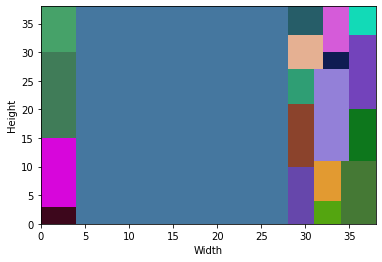


Paper dimensions: 39x39
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]
(:added-eqs                 577774
 :arith-assert-diseq        2557987
 :arith-assert-lower        3544418
 :arith-assert-upper        3524060
 :arith-bound-prop          434179
 :arith-conflicts           42032
 :arith-eq-adapter          2781
 :arith-fixed-eqs           28622
 :arith-num-rows            2436
 :arith-offset-eqs          266709
 :arith-pivots              327555
 :arith-row-summations      21267395
 :arith-tableau-max-columns 2613
 :arith-tableau-max-rows    2436
 :binary-propagations       9279524
 :conflicts                 2479504
 :dd-assertions             34599245
 :dd-propagations           507728425
 :decisions                 4706332
 :del-clause                2449378
 :max

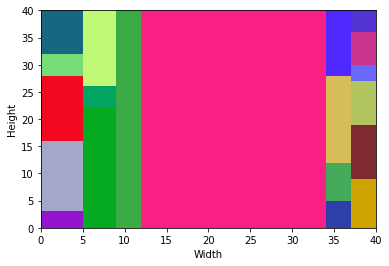


Instance size / Running time plot:


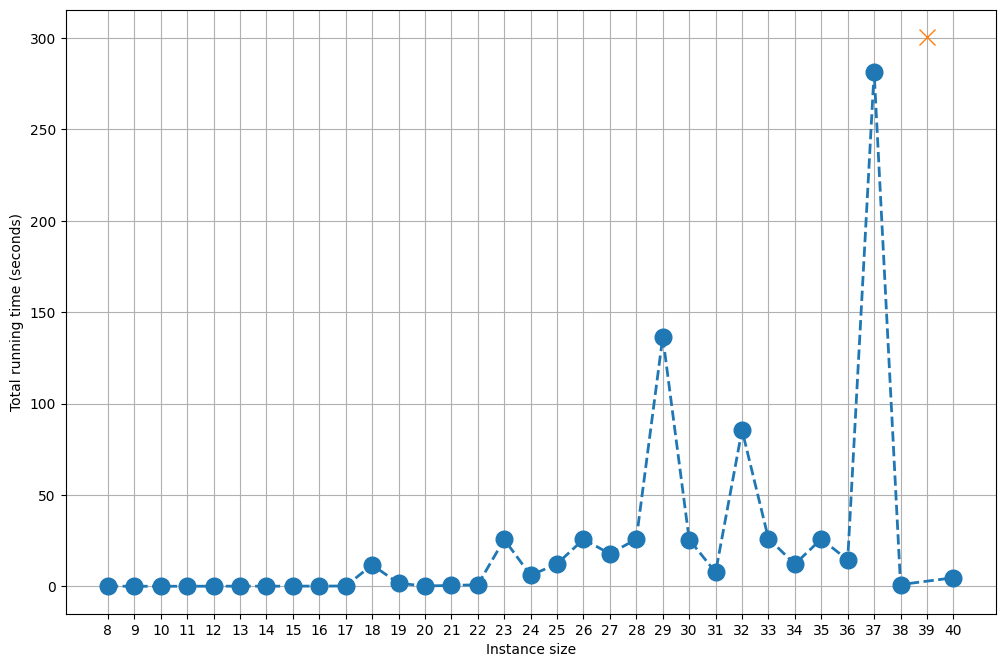

In [210]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    instances.append(i)
    current_instance = f"{i}x{i}"
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    print(f"Paper dimensions: {current_instance}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    bl_corners, model = smt_v1(w_paper, h_paper, n, presents)
    model.set("timeout", max_time)
    is_feasible = model.check()
    end_time = time()
    total_time = end_time - start_time
    times.append(total_time)
    print(model.statistics())
    print(f"Total running time: {round(total_time, 3)} seconds")
    if is_feasible == sat:
        assignment = model.model()
        bl_corners = [
            [
                assignment[bl_corners[i][0]].as_long(), 
                assignment[bl_corners[i][1]].as_long()
            ] for i in range(n)
        ]
        solution = {'bl_corners': bl_corners}
        show_solutions(w_paper, h_paper, n, presents, solution, model='smt')
    print()
    
if len(instances) > 1:        
    print("Instance size / Running time plot:")
    show_running_times(instances, times, max_time, model='smt')

### First model

In this first SMT model we tried to re-implement the same ideas as in the CP models above, converting code from MiniZinc to be compatible with Z3 specifications. 

In particular, the following constraints turned out to be useful:
* The `diffn` global constraint is used to ensure rectangles non-overlapment
* Constraints for domain reductions, such as top right corners and the existence of a fixed positioning of exactly one rectangle at the origin (for bottom left corners) and one at the wrapping paper border (for top right corners)
* Constraints to ensure that the total occupied area is equal to all the available wrapping paper surface
* The `alldifferent` global constraint was added to check that every bottom left corner is different w.r.t. all the others

Instead, the following constraints were removed from the model, since they resulted in an overall slowdown:
* The `cumulative` global constraint was added for both the x and y axis
* Constraints to check that the actual occupied area of each rectangle is equal to its size
* A symmetry breaking constraint was added to check that the rectangle with the biggest area should be placed to the left and below the second biggest rectangle

In [188]:
def smt_v1(w_paper, h_paper, n, presents):
    # Constants
    # _, sorted_indices = order_presents(presents, method='area', reverse=True)
    presents_xs = [presents[i][0] for i in range(n)]
    presents_ys = [presents[i][1] for i in range(n)]
    areas = [presents[i][0] * presents[i][1] for i in range(n)]
    area = w_paper * h_paper;
    
    # Variables
    bl_corners = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
    bl_corners_xs = [bl_corners[i][0] for i in range(n)]
    bl_corners_ys = [bl_corners[i][1] for i in range(n)]
    tr_corners = [[bl_corners[i][j] + presents[i][j] for j in range(2)] for i in range(n)]
    actual_areas = [(tr_corners[i][0] - bl_corners[i][0]) * (tr_corners[i][1] - bl_corners[i][1]) for i in range(n)]
    
    # Constraints
    bl_corners_domain = [
        And(
            0 <= bl_corners[i][0], bl_corners[i][0] <= w_paper - presents[i][0], 
            0 <= bl_corners[i][1], bl_corners[i][1] <= h_paper - presents[i][1]
        ) for i in range(n)
    ]
    tr_corners_domain = [
        And(
            presents[i][0] <= tr_corners[i][0], tr_corners[i][0] <= w_paper, 
            presents[i][1] <= tr_corners[i][1], tr_corners[i][1] <= h_paper, 
        ) for i in range(n)
    ]
    no_overlap = z3_diffn(bl_corners_xs, bl_corners_ys, presents_xs, presents_ys)
    one_at_zero = Or([And(bl_corners[i][0] == 0, bl_corners[i][1] == 0) for i in range(n)])
    one_at_max = Or([And(tr_corners[i][0] == w_paper, tr_corners[i][1] == h_paper) for i in range(n)])
    occupied_area = Sum(actual_areas) == area
    alldiff = z3_alldifferent_mat(bl_corners, s=2)
    
    # Non-optimal constraints
    '''
    x_bound = z3_cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper, 0, w_paper - 1);
    y_bound = z3_cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper, 0, h_paper - 1);
    actual_occupied_area = [actual_areas[i] == areas[i] for i in range(n)]
    symmetry_breaking = Implies(
        bl_corners[sorted_indices[0]][1] >= bl_corners[sorted_indices[1]][1],
        bl_corners[sorted_indices[0]][0] < bl_corners[sorted_indices[1]][0]
    )
    '''

    # Model checking
    model = Solver()
    model.add(
        bl_corners_domain + 
        tr_corners_domain + 
        no_overlap + 
        alldiff +
        [one_at_zero] + 
        [one_at_max] + 
        [occupied_area]
    )
    return bl_corners, model